## 모듈 불러오기

In [10]:
from array import array
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cv2
import matplotlib.pyplot as plt
import jenkspy

## IR, RGB 이미지 불러오기

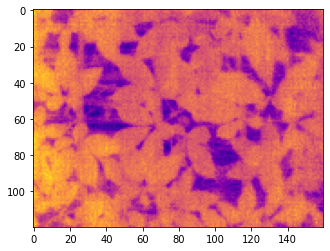

In [11]:
import util
import cv2
import matplotlib.pyplot as plt

WIDTH = 160
HEIGHT = 120

ir_image = util.load_ir_in_dat('./ginseng-ir/irimage_20220728_0903.dat')

# RGB 이미지 불러오기
rgb_image = cv2.imread('./ginseng-rgb/1.jpeg')
rgb_image = cv2.resize(rgb_image,
                       dsize=(WIDTH, HEIGHT),
                       interpolation=cv2.INTER_AREA)

plt.imshow(ir, cmap='plasma')
plt.show()


# Excess-green(exg) 인덱스를 Jenks Natural Breaks로 클러스터링

In [12]:
import numpy as np
import jenkspy

# excess-green
exg = np.zeros(shape=rgb_image.shape[:-1])
for row, col, _channel in np.ndindex(rgb_image.shape):
    b, g, r = rgb_image[row][col] / rgb_image[row][col].sum()
    exg[row][col] = 2 * g - r - b


breaks = jenkspy.jenks_breaks(exg.ravel(), nb_class=2)

fig = px.imshow(exg, title='excess-green index')
fig.show()

exg_region = np.zeros(shape=exg.shape, dtype=np.uint8)
for row, col in np.ndindex(exg_region.shape):
    exg_region[row, col] = 0xFF if breaks[1] <= exg[row, col] else 0

fig = px.imshow(exg_region, title='exg 클러스터링 결과')
fig.show()


# IR 이미지를 클러스터링

In [13]:
from sklearn.metrics import confusion_matrix
ir_breaks = jenkspy.jenks_breaks(ir_image.ravel(), nb_class=2)

ir_region = np.zeros(shape=ir_image.shape[:2], dtype=np.uint8)
for row, col in np.ndindex(ir_image.shape):
    ir_region[row, col] = 0xFF if ir_breaks[1] < ir_image[row, col] else 0

fig = px.imshow(ir_region, title='IR 이미지로 분류한 영역')
fig.show()

tn, fp, fn, tp = confusion_matrix(
    exg_region.ravel(), ir_region.ravel()).ravel()
print('TP:', tp)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)

print('정확도: ', (tp + tn) / (tp + tn + fp + fn))


TP: 10553
FP: 3878
FN: 2740
TP: 10553
정확도:  0.6553125


In [14]:
img = cv2.bitwise_and(cv2.cvtColor(ir_region, cv2.COLOR_GRAY2BGR), rgb_image)

fig = px.imshow(img, title='IR 영역 + RGB 이미지')
fig.show()

In [15]:
from array import array
import numpy as np
import plotly.express as px
import cv2


def load_ir_image(file_name):
    with open(file_name, 'rb') as file:
        bytes = file.read(WIDTH * HEIGHT * 2)

    ir_array = array('H')
    ir_array.frombytes(bytes)

    ir_image = np.array(ir_array).reshape(HEIGHT, WIDTH)
    ir_image = (ir_image - 27315) / 100
    return ir_image




3. Threshold 이진화

In [16]:
def threshold(img, start, end):
    bin_img = np.zeros(shape=img.shape,
                       dtype=np.uint8)

    for row, col in np.ndindex(bin_img.shape):
        bin_img[row, col] = 0xFF if start <= img[row, col] and img[row, col] <= end else 0

    return bin_img


4. 영역 내 평균 온도 구하기

In [17]:
def get_average_tempeature(img, region):
    num_pixels = 0
    sum_temperature = 0
    for y, x in np.ndindex(img.shape):
        if region[y, x] != 0:
            sum_temperature += img[y, x]
            num_pixels += 1
    
    return sum_temperature / num_pixels

# main

In [18]:
img = load_ir_image('./ginseng-ir/irimage_20220728_0903.dat')

hist, bin_edges = np.histogram(img, bins=256)
FREQUENCY = 500
indices = np.argwhere(hist > FREQUENCY)
start = bin_edges[indices[0, 0]]
end = bin_edges[indices[-1, 0] + 1]
bin_img = threshold(img, start, end)

# 열화상 이미지 출력
show_image(img, '열화상 이미지')

# 필터 영역 표시
show_image(bin_img, f'히스토그램 내 빈도수가 500 이상인 영역({start:.2f}~{end:.2f})')

# 히스토그램 출력
show_histogram(img)
print(f"잎의 평균 온도: {get_average_tempeature(img, bin_img):.2f}")



NameError: name 'show_image' is not defined